### 1. Youtube 댓글 크롤링 & 분석(검색어: 타다 금지법)

- (1) 기간: [정확한 기간 확인 필요] 에 '타다 금지법'으로 업로드 된 동영상
- (2) 수집 데이터: 일자, 동영상 제목, 사용자 id, 댓글, 좋아요 수
- (3) 검색 필터 정렬: '관련성' 기준

### 2. Scrapy Code 

#### 1) 프로젝트 생성

In [3]:
!rm -rf youtube/

In [4]:
!scrapy startproject youtube

#### 2) items.py 작성

In [5]:
!cat youtube/youtube/items.py

In [6]:
%%writefile youtube/youtube/items.py

import scrapy

class YoutubeItem(scrapy.Item):
    title = scrapy.Field()
    user_id = scrapy.Field()
    comment = scrapy.Field()
    like_num = scrapy.Field()
    link = scrapy.Field()

Overwriting youtube/youtube/items.py


#### 3) spider.py 작성

In [7]:
%%writefile youtube/youtube/spiders/spider.py

import requests
import time
import scrapy

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from scrapy.http import TextResponse
from bs4 import BeautifulSoup
from youtube.items import YoutubeItem
from scrapy.spiders import Spider

class YoutubeCrawler(scrapy.Spider):
    item = YoutubeItem()
    name = "YoutubeCrawler"   
    allow_domains = ["youtube.com"]
    start_urls = ['https://www.youtube.com/results?search_query=타다 금지법&sp=EgYIBBABGAE%253D']
       
    def __init__(self):
        scrapy.Spider.__init__(self)
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome('/home/ubuntu/chromedriver', options=options)
        
    def parse(self, response):
        self.driver.get(response.url)
    
        time.sleep(2)
        page=self.driver.page_source

        soup = BeautifulSoup(page,'lxml')
        all_ = soup.find_all('a','yt-simple-endpoint style-scope ytd-video-renderer')
        
        #유튜브 첫 화면에서 이번달 업로드된 동영상 링크
        links= ["https://www.youtube.com/" + all_[n].get('href') for n in range(0,len(all_))]
        
        for link in links:
            yield scrapy.Request(link, callback=self.get_content)
        
    def get_content(self, response): #세부 링크 response
        time.sleep(10)
        self.driver.get(response.url)
        
        #모든 댓글 가져오기 위해, 페이지 스크롤 끝까지 내리기
        body = self.driver.find_element_by_tag_name("body")
        
        num_of_pagedowns = 30
        
        last_page_height = self.driver.execute_script("return document.documentElement.scrollHeight")

        while True: 
            self.driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);") 
            time.sleep(10.0) 
            new_page_height = self.driver.execute_script("return document.documentElement.scrollHeight") 
            
            if new_page_height == last_page_height: 
                break 
            
            last_page_height = new_page_height

        #댓글: 최근 날짜 순으로 정렬
            try: 
                self.driver.find_element_by_xpath('//*[@id="sort-menu"]').click() 
                self.driver.find_element_by_xpath('//*[@id="menu"]/a[2]/paper-item/paper-item-body/div[text()="최근 날짜순"]').click() 
        
            except Exception as e: 
                pass       
        
            #제목
            title = self.driver.find_element_by_css_selector('#container > h1 > yt-formatted-string').text
            #사용자 id    
            user_ids = self.driver.find_elements_by_css_selector('#author-text > span')
            #댓글
            comments = self.driver.find_elements_by_css_selector('#content-text')
            #좋아요 수
            like_nums = self.driver.find_elements_by_css_selector('#vote-count-middle')
            
        for j in range(0, len(comments)):    
            item = YoutubeItem()
            item["title"] = title
            item["comment"] = comments[j].text
            item["user_id"] = user_ids[j].text
            item["like_num"] = like_nums[j].text
            item["link"] = response.url
            
            yield item  

Overwriting youtube/youtube/spiders/spider.py


In [8]:
%%writefile run.sh
cd youtube
scrapy crawl YoutubeCrawler -o YoutubeCrawling.csv

Overwriting run.sh


In [10]:
!./run.sh

#### 4) pipeline.py 설정(pymongo 연결)

In [11]:
%%writefile youtube/youtube/mongodb.py 

import pymongo

client = pymongo.MongoClient('mongodb://ip:ip@ip.ip.ip.ip:ip')

db = client.youtube
collection = db.result2

Overwriting youtube/youtube/mongodb.py


In [12]:
!cat youtube/youtube/pipelines.py


import json
import requests
from .mongodb import collection

from .mongodb import collection

class YoutubePipeline(object):

    def process_item(self, item, spider):
        data = {"title": item["title"], 
                "user_id": item["user_id"], 
                "comment": item["comment"], 
                "like_num" : item["like_num"],
                "link": item["link"]}
        collection.insert(data)

        return item


In [9]:
%%writefile youtube/youtube/pipelines.py

from .mongodb import collection

class YoutubePipeline(object):

    def process_item(self, item, spider):
        data = {"title": item["title"], 
                "user_id": item["user_id"], 
                "comment": item["comment"], 
                "like_num" : item["like_num"]}
        collection.insert(data)

        return item

Overwriting youtube/youtube/pipelines.py


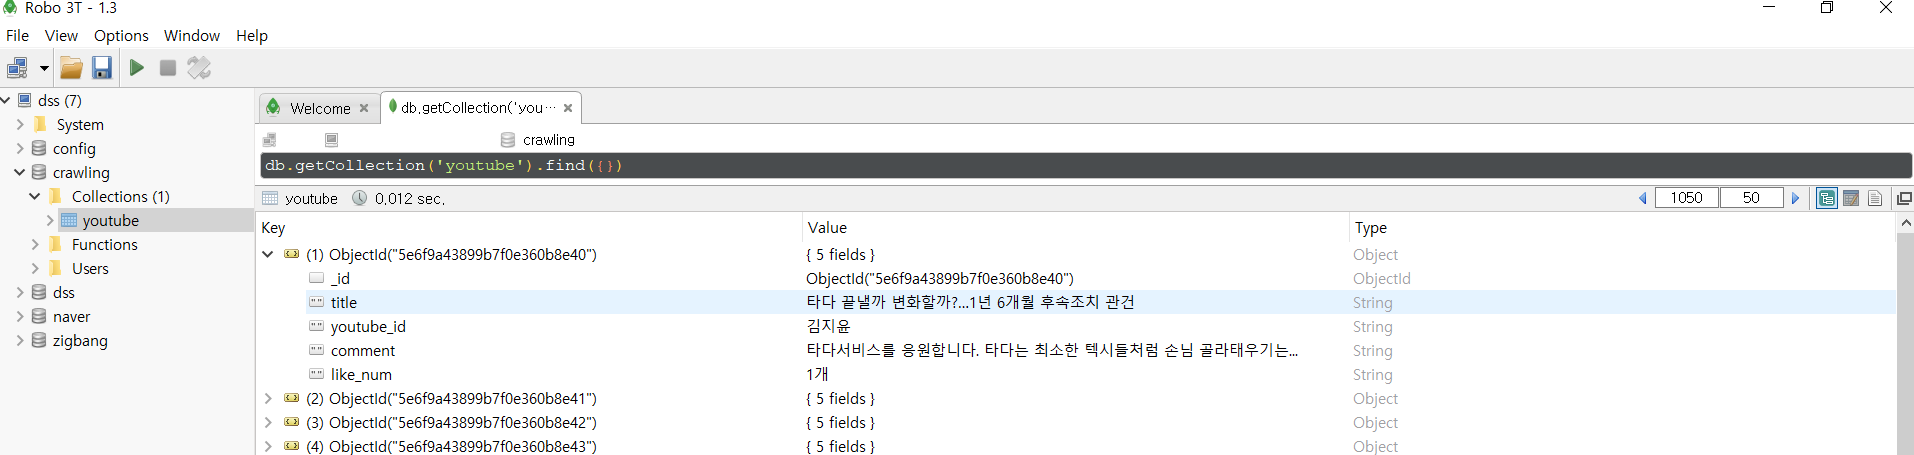

In [5]:
# 몽고 db 저장 결과
from PIL import Image

page = Image.open("./image.png")
page

In [ ]:
# settings.py 파일 수정
#ITEM_PIPELINES = {
    #'naver_article.pipelines.NaverArticlePipeline': 300,
#}

In [ ]:
#!./run.sh

2020-03-17 20:43:03 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: youtube)
2020-03-17 20:43:03 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.6.9 (default, Jan 20 2020, 02:55:31) - [GCC 7.4.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Linux-4.15.0-1060-aws-x86_64-with-debian-buster-sid
2020-03-17 20:43:03 [scrapy.crawler] INFO: Overridden settings: {'BOT_NAME': 'youtube', 'FEED_FORMAT': 'csv', 'FEED_URI': 'YoutubeCrawling.csv', 'NEWSPIDER_MODULE': 'youtube.spiders', 'SPIDER_MODULES': ['youtube.spiders']}
2020-03-17 20:43:03 [scrapy.extensions.telnet] INFO: Telnet Password: 1112710ccb8e33f4
2020-03-17 20:43:03 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogSt